<a href="https://colab.research.google.com/github/TrueBalkar/Test_WT/blob/main/jupyter%20notebook%20with%20exploratory%20data%20analysis%20of%20the%20dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip uninstall -y Kaggle
! pip install Kaggle
from google.colab import files
files.upload()

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 58 kB 2.8 MB/s 
  Created wheel for Kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=40a5b170fba6f2492fa68304a4c0a7500d6fb2397fdbb1452c350d409526bdbc
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built Kaggle


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"a12000","key":"48ae0a63ffdcce9a7d1a9ace822e5ff4"}'}

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download airbus-ship-detection

100% 28.6G/28.6G [09:38<00:00, 54.2MB/s]
100% 28.6G/28.6G [09:39<00:00, 53.0MB/s]


In [ ]:
! unzip /content/airbus-ship-detection

In [ ]:
! rm airbus-ship-detection.zip

In [ ]:
! pip install patchify
! pip install segmentation_models

     |████████████████████████████████| 50 kB 2.7 MB/s 


In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import shutil
from keras.layers import Conv2D, Input, Dropout, concatenate, UpSampling2D, \
                         MaxPooling2D, BatchNormalization, Activation, Conv2DTranspose
from keras import Model, backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [80]:
# Load data
path = "/content/"
masks = pd.read_csv(rf"{path}train_ship_segmentations_v2.csv")
print(f"train_ship_segmentations_v2.csv:\n\n{masks}")

train_ship_segmentations_v2.csv:

              ImageId                                      EncodedPixels
0       00003e153.jpg                                                NaN
1       0001124c7.jpg                                                NaN
2       000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3       000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4       000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...               ...                                                ...
231718  fffedbb6b.jpg                                                NaN
231719  ffff2aa57.jpg                                                NaN
231720  ffff6e525.jpg                                                NaN
231721  ffffc50b4.jpg                                                NaN
231722  ffffe97f3.jpg                                                NaN

[231723 rows x 2 columns]


In [78]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
print(f"{unique_img_ids}")

              ImageId  ships
0       00003e153.jpg      0
1       0001124c7.jpg      0
2       000155de5.jpg      1
3       000194a2d.jpg      5
4       0001b1832.jpg      0
...               ...    ...
192551  fffedbb6b.jpg      0
192552  ffff2aa57.jpg      0
192553  ffff6e525.jpg      0
192554  ffffc50b4.jpg      0
192555  ffffe97f3.jpg      0

[192556 rows x 2 columns]


In [76]:
unique_img_ids['is_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)

print(f"Count of images with/withot ships \n{unique_img_ids['is_ship'].value_counts()}")

Count of images with/withot ships 
0.0    150000
1.0     42556
Name: is_ship, dtype: int64


In [77]:
print(f"Count of images with number (0, 1, 2 etc.) of ships \n{unique_img_ids['ships'].value_counts()}")

Count of images with number (0, 1, 2 etc.) of ships 
0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: ships, dtype: int64


In [69]:
print(unique_img_ids)

              ImageId  ships  is_ship
0       00003e153.jpg      0      0.0
1       0001124c7.jpg      0      0.0
2       000155de5.jpg      1      1.0
3       000194a2d.jpg      5      1.0
4       0001b1832.jpg      0      0.0
...               ...    ...      ...
192551  fffedbb6b.jpg      0      0.0
192552  ffff2aa57.jpg      0      0.0
192553  ffff6e525.jpg      0      0.0
192554  ffffc50b4.jpg      0      0.0
192555  ffffe97f3.jpg      0      0.0

[192556 rows x 3 columns]


In [86]:
# Here you can choose how much ships do you want to see on an image - variable 'num_ships'
num_ships = 1
print(f"ImageId's with {num_ships} ships on it \n{unique_img_ids.loc[unique_img_ids.ships == num_ships, 'ImageId']}")

ImageId's with 1 ships on it 
2         000155de5.jpg
9         00031f145.jpg
12        00053c6ba.jpg
16        0005d6d95.jpg
17        0006c52e8.jpg
              ...      
192522    fff67c31a.jpg
192524    fff77c602.jpg
192528    fff909871.jpg
192543    fffcb6464.jpg
192547    fffdd2377.jpg
Name: ImageId, Length: 27104, dtype: object


In [85]:
# Here you can choose how much ships do you want to see on an image - variable 'num_ships'
num_ships = 8
print(f"ImageId's with {num_ships} ships on it \n{unique_img_ids.loc[unique_img_ids.ships == num_ships, 'ImageId']}")

ImageId's with 8 ships on it 
1985      02a608cf8.jpg
2610      0372121e8.jpg
2885      03d4bafb1.jpg
2902      03dc71fb4.jpg
2996      040073f20.jpg
              ...      
189535    fbfd0d840.jpg
190267    fcf2f2bd2.jpg
190287    fcf8aa709.jpg
191068    fe09d241c.jpg
192212    ff83ead39.jpg
Name: ImageId, Length: 318, dtype: object


In [87]:
# Here you can choose how much ships do you want to see on an image - variable 'num_ships'
num_ships = 15
print(f"ImageId's with {num_ships} ships on it \n{unique_img_ids.loc[unique_img_ids.ships == num_ships, 'ImageId']}")

ImageId's with 15 ships on it 
1208      01914baf2.jpg
1861      02776139a.jpg
2579      0368beab8.jpg
3183      0445b541d.jpg
3438      04a2c262a.jpg
              ...      
176401    ea9f82665.jpg
179547    eec04e7a8.jpg
186407    f7e6819bb.jpg
190392    fd1de824c.jpg
192184    ff7ac7f3c.jpg
Name: ImageId, Length: 66, dtype: object


In [65]:
# Function to encode mask
def rle_decode(mask_rle, IMG_SIZE = (768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 255 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(IMG_SIZE[0]*IMG_SIZE[1])
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 255
    return img.reshape(IMG_SIZE).T

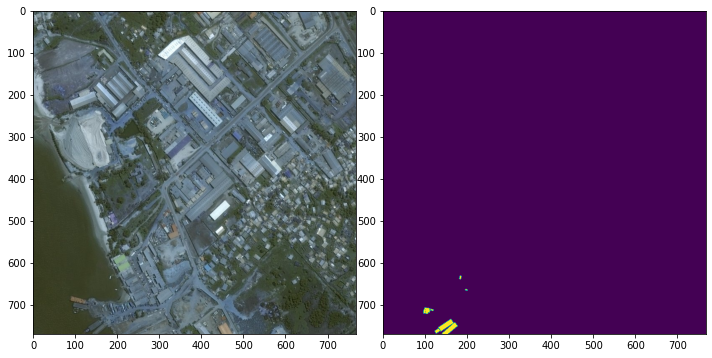

In [67]:
def display(ImageId):

    img = cv2.imread('/content/train_v2/' + ImageId)
    img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768))
    for mask in img_masks:
        all_masks += rle_decode(mask, (768, 768))

    fig, axarr = plt.subplots(1, 2, figsize=(10, 20))
    axarr[0].imshow(img)
    axarr[1].imshow(all_masks)
    plt.tight_layout(h_pad=0.1, w_pad=0.1) # to adjust automatically axis to subplot area
    plt.show()

display('00021ddc3.jpg')

In [90]:
model = load_model("/content/drive/MyDrive/model_weights/model_4.h5",
                   custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                   'jacard_coef': jacard_coef})

In [91]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

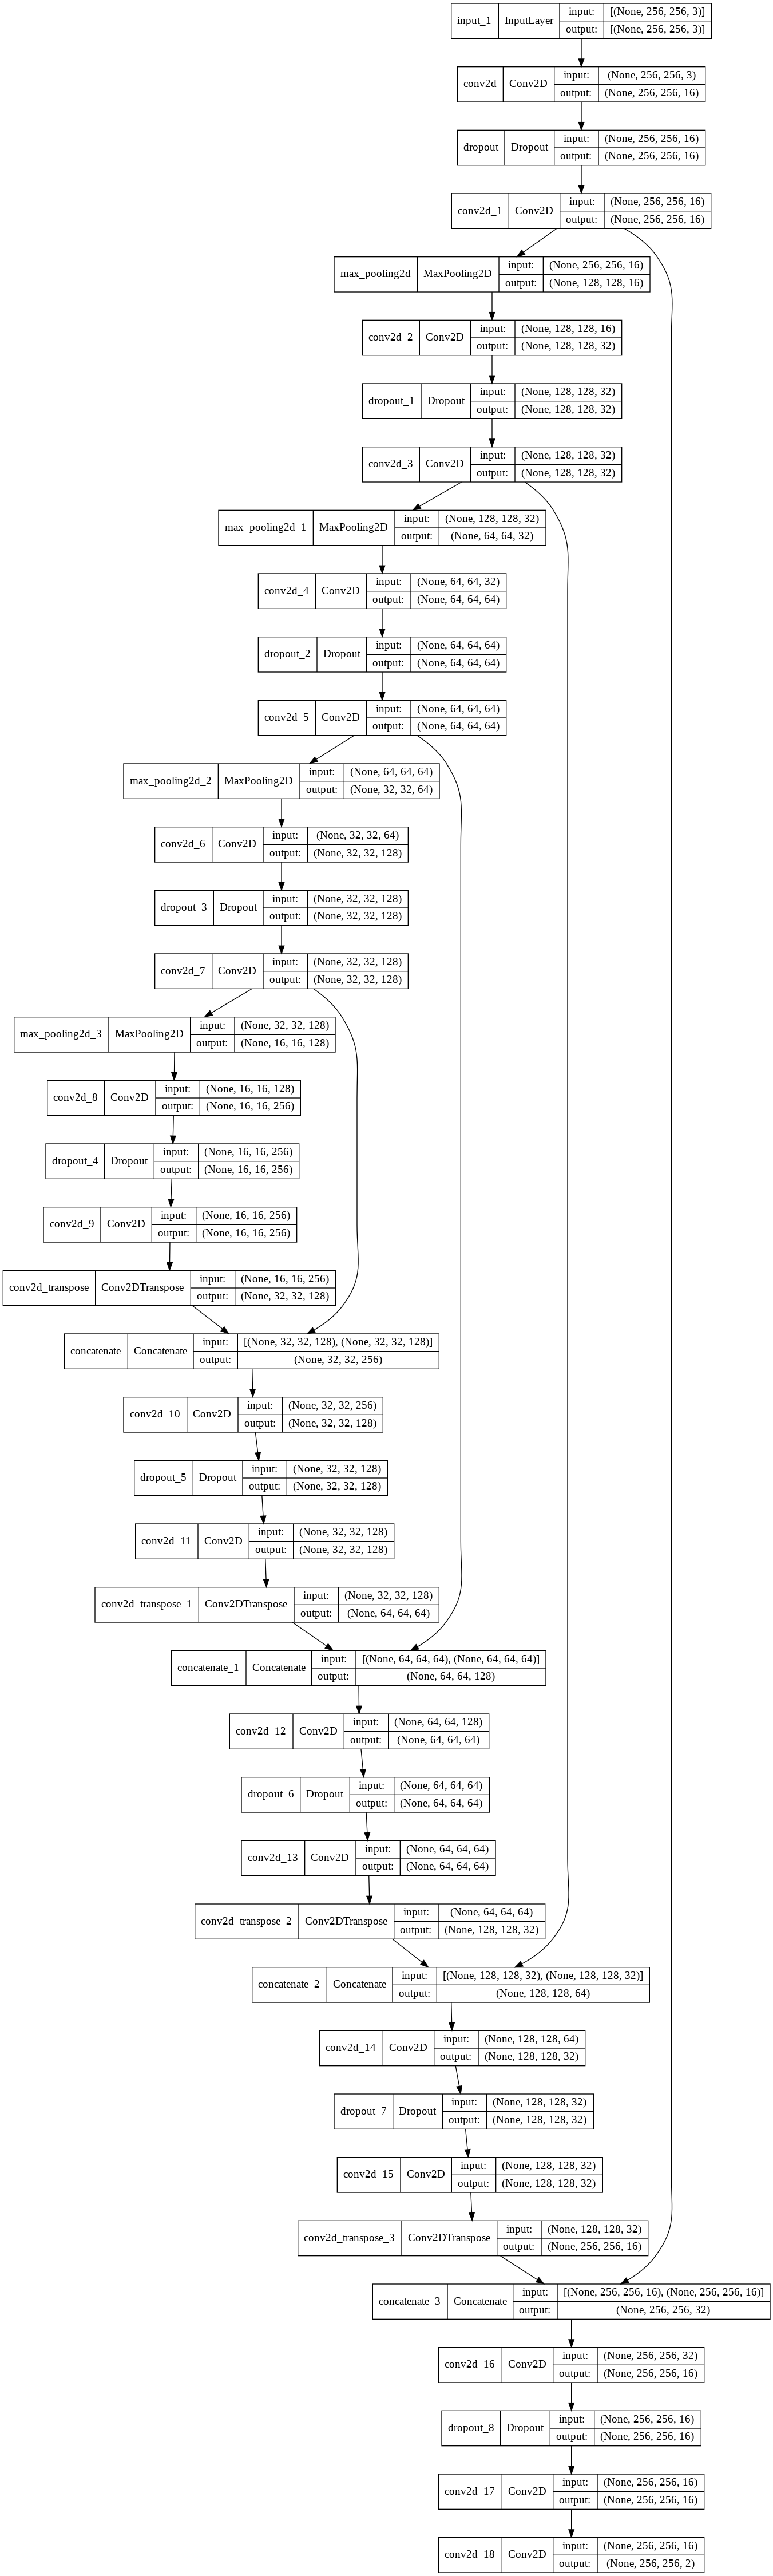

In [99]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [100]:
"""
...
...
...
Lots of code
...
...
...
"""

y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

# Using built in keras function for IoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Accuracy or Mean IoU of the model =", IOU_keras.result().numpy())

Accuracy or Mean IoU of the model = 0.83835983
